# K-means clustering

Използвайте алгоритъма kMeans, за да се определят автоматично групи от сходни елементи за наборите от данни normal.txt и unbalance.txt

Вход:
Име на файл и брой клъстери 

Изход:
Картинка, която показва клъстери в различни цветове. (Всички примери от приложените бази са описани чрез два атрибута - x и y, които са разположението на точката в евклидовото простанство)

* В решението приложете Random Restart с оценка колко са добри постигнатите клъстери. Като оценка можете да ползвате "вътрешно клъстерно разстояние", "междуклъстерно разстояние" и комбинация от двете. Опитайте се да сравните резултатите(можете да сравните и с оценка различна от предложените).

* Като допълнение можете да приложите ***kMeans++*** и да сравните резултатите.
* Като допълнение можете да приложите ***Soft kMeans*** и да сравните резултатите. 


In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import argparse
from typing import List, Dict

In [2]:
def read_data(filepath) -> np.ndarray:
    points: List[List[float]] = []

    try:
        with open(filepath, 'r') as file:
            points = [list(map(float, line.split())) 
                      for line in file.readlines()]
    except Exception as e:
        print(f"Reading error{e}")

    points: np.ndarray = np.array(points)

    return points


In [3]:
points_unbalanced: np.ndarray = read_data("./unbalance.txt")
points_normal: np.ndarray = read_data("./normal.txt")

In [4]:
class KMeans:
    TOLERANCE: float = 1e-4
    
    def __init__(self, 
                 points: np.ndarray, 
                 initialization="KM++", 
                 k: int = 8) -> None:
        self.points: np.ndarray = points
        self.centroids: List[np.ndarray] = []
        self.assignments: np.ndarray = np.array([-1 for _ in range(len(self.points))])# ids of clusters
    
        if initialization == "KM++":
            self.kmpp_init(k)
        else:
            self.rand_init(k)
        self.initialization = initialization
        self.intra_cluster_distance = float("inf")
        self.assign()

    @property
    def K(self) -> int:
        return len(self.centroids)

    def rand_init(self, k: int) -> None:
        indx: np.ndarray = np.random.choice(np.arange(len(self.points)), k, replace=False)
        self.centroids = self.points[indx]

    @property
    def cost(self) -> float:
        temp: float = 0.0
        for i, c in enumerate(self.centroids):
            for pid, p in enumerate(self.points):
                temp += (np.linalg.norm(p - c) ** 2) * (self.assignments[pid] == i)
        return temp

    def assign(self) -> None:
        cost = 0
        temp = []
        for point in self.points:
            dists = [np.linalg.norm(c - point) for c in self.centroids]
            temp.append(dists.index(min(dists)))
            cost += dists[temp[-1]]
        self.assignments = np.array(temp)
        self.intra_cluster_distance = cost


    def compute_centroids(self) -> bool:
        converged: bool = True
        for i in range(len(self.centroids)):
            relevant = self.assignments == i
            old_val: np.ndarray = np.copy(self.centroids[i])
            
            if not np.any(relevant):
                self.centroids[i] = self.random_point
            else:
                self.centroids[i] = np.mean(self.points[relevant], axis=0)
            
            if np.linalg.norm(old_val - self.centroids[i]) > KMeans.TOLERANCE:
                converged = False
            
        return converged

    @property
    def random_point(self) -> np.ndarray:
        return self.points[int(np.random.choice(np.arange(len(self.points)), 1, replace=False))]

    def run(self) -> None:
        while not self.compute_centroids():
            self.assign()

    def kmpp_init(self, k: int) -> None:
        """
        Kmeans++ initialization
        """
        self.centroids.append(self.random_point)

        for _ in range(k - 1):
            distances = np.array([min(np.linalg.norm(point - c) ** 2 
                                 for c in self.centroids) for point in self.points])
            
            probabilities = distances / distances.sum()
            
            next_centroid_id = np.random.choice(len(self.points), p=probabilities)
            self.centroids.append(self.points[next_centroid_id])

        self.centroids = np.array(self.centroids)

    def plot_clusters(self):
        x = self.points[:, 0]
        y = self.points[:, 1]
        title = f"KMeans with {self.initialization} initialization, K = {self.K}"
        plt.scatter(x=x, y=y, c=self.assignments)
        c_x = self.centroids[:, 0]
        c_y = self.centroids[:, 1]
        plt.scatter(c_x, c_y, marker='x', color='k')
        plt.title(title)
        plt.show()
        


## Cluster plot

In [5]:
def restart(initialization, points, K=8, runs=5):
    best = None
    best_dist = float('inf')

    for _ in range(runs):
        temp = KMeans(points, initialization=initialization, k=K)
        temp.run()
        cost = temp.cost
        if cost < best_dist:
            best = temp
            best_dist = cost

    best.plot_clusters()

#### On the unbalanced dataset

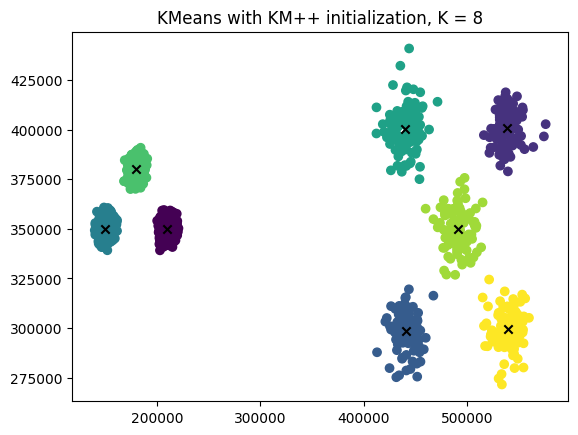

In [6]:
restart("KM++", points_unbalanced)

❓Is the elbow method applicable

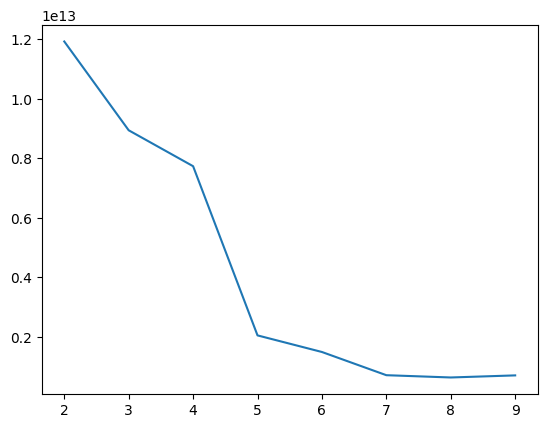

In [7]:
ks: np.ndarray = list(range(2, 10))
costs = [KMeans(points_unbalanced, initialization="KM++", k=k).cost for k in ks]

plt.plot(ks, costs)

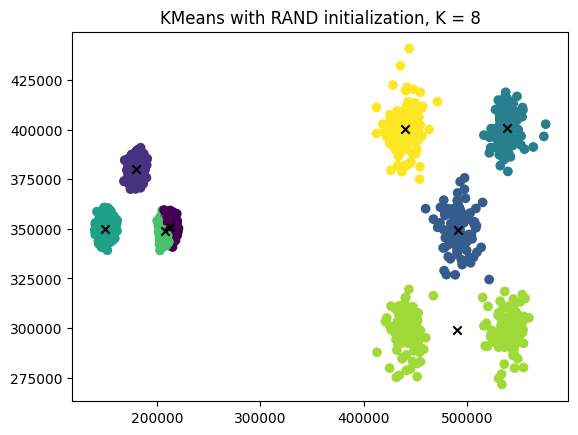

In [8]:
restart("RAND", points_unbalanced)

#### On the 'normal' dataset

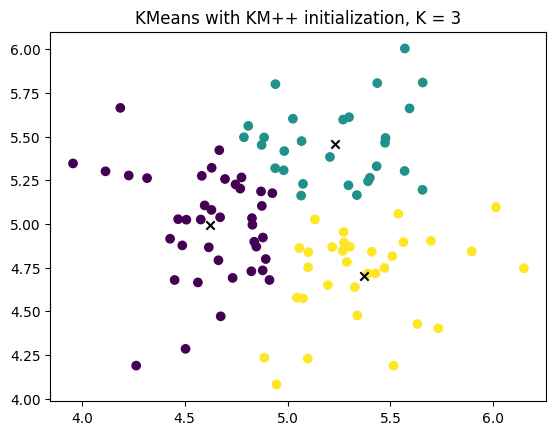

In [9]:
restart("KM++", points_normal, K=3)

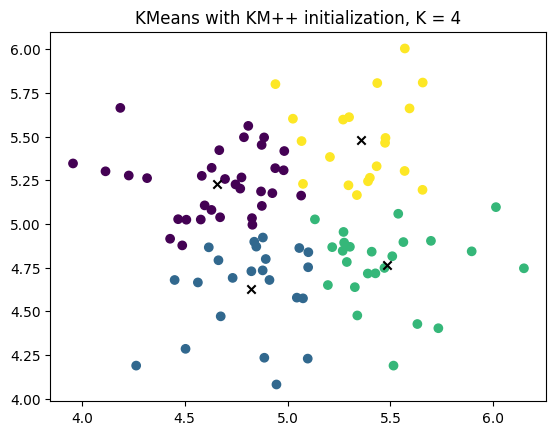

In [10]:
restart("KM++", points_normal, K=4)

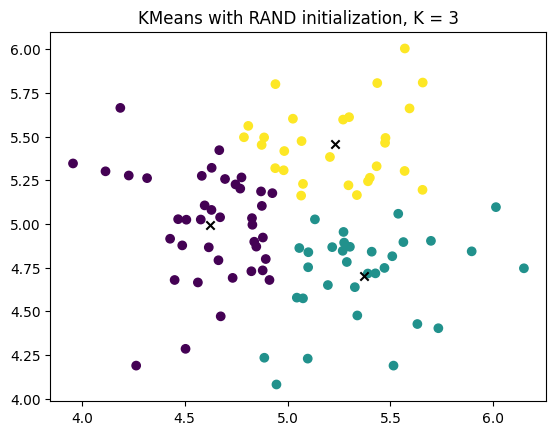

In [11]:
restart("RAND", points_normal, K=3)

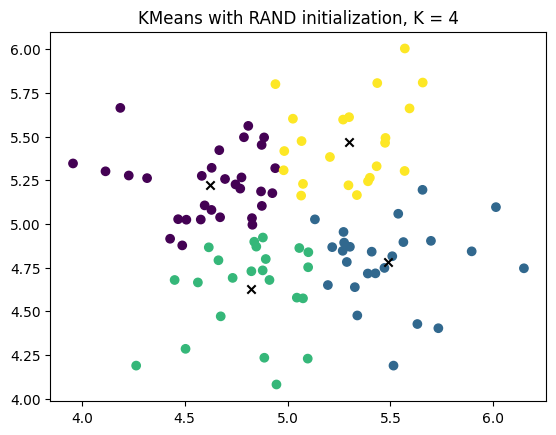

In [12]:
restart("RAND", points_normal, K=4)

## Fuzzy CMeans

In [13]:
class CMeans:
    M: float = 1.001 # stiffness parameter
    TOLERANCE: float = 1e-4
    def __init__(self, 
                 points: np.ndarray, 
                 initialization="KM++", 
                 k: int = 8) -> None:
        self.points: np.ndarray = points
        self.centroids: List[np.ndarray] = []
        self.membership_values: np.ndarray = None
    
        if initialization == "KM++":
            self.kmpp_init(k)
        else:
            self.rand_init(k)
        self.initialization = initialization
        self.assign()

    @property
    def K(self) -> int:
        return len(self.centroids)

    def rand_init(self, k: int) -> None:
        indx: np.ndarray = np.random.choice(np.arange(len(self.points)), k, replace=False)
        self.centroids = self.points[indx]

    @property
    def cost(self) -> float:
        temp: float = 0.0
        for i, c in enumerate(self.centroids):
            for pid, p in enumerate(self.points):
                temp += (np.linalg.norm(p - c) ** 2) * (self.membership_values[pid][i] ** CMeans.M)
        return temp

    def assign(self) -> None:
        temp = []
        for point in self.points:
            dists = np.array([np.linalg.norm(c - point) for c in self.centroids])
            dists[dists == 0] = 0.0001
            memberships = 1 / np.array([np.sum((dist_j / dists) ** (2 / (CMeans.M - 1))) for dist_j in dists])
            temp.append(memberships)
        self.membership_values = np.array(temp)


    def compute_centroids(self) -> bool:
        converged: bool = True
        for i in range(len(self.centroids)):
            exp_weights = self.membership_values[:, i] ** CMeans.M
            old_centroid = np.copy(self.centroids[i])

            self.centroids[i] = np.sum(self.points.transpose() * exp_weights, axis=1) / np.sum(exp_weights) 
            
            if np.linalg.norm(old_centroid - self.centroids[i]) > CMeans.TOLERANCE:
                converged = False
        
        return converged


    @property
    def random_point(self) -> np.ndarray:
        return self.points[int(np.random.choice(np.arange(len(self.points)), 1, replace=False))]

    def run(self) -> None:
        while not self.compute_centroids():
            self.assign()
            # print(self.cost)

    def kmpp_init(self, k: int) -> None:
        """
        Kmeans++ initialization
        """
        self.centroids.append(self.random_point)

        for _ in range(k - 1):
            distances = np.array([min(np.linalg.norm(point - c) ** 2 
                                 for c in self.centroids) for point in self.points])
            
            probabilities = distances / distances.sum()
            
            next_centroid_id = np.random.choice(len(self.points), p=probabilities)
            self.centroids.append(self.points[next_centroid_id])

        self.centroids = np.array(self.centroids)

    def plot_clusters(self):
        colors = np.argmax(self.membership_values, axis=1)  # Assign each point to the cluster with the maximum membership value
        x = self.points[:, 0]
        y = self.points[:, 1]

        plt.scatter(x, y, c=colors)
        c_x = self.centroids[:, 0]
        c_y = self.centroids[:, 1]
        plt.scatter(c_x, c_y, marker='x', color='k')  # Mark centroids with 'x'
        plt.title(f"Fuzzy C-Means Clustering with {self.initialization} Initialization, K = {self.K}")
        plt.show()

In [15]:
def restart(initialization, points, K=8, runs=5):
    best = None
    best_dist = float('inf')

    for _ in range(runs):
        temp = CMeans(points, initialization=initialization, k=K)
        temp.run()
        cost = temp.cost
        if cost < best_dist:
            best = temp
            best_dist = cost

    best.plot_clusters()

# temp.membership_values



/tmp/ipykernel_25261/859190980.py:40: RuntimeWarning: overflow encountered in power
  memberships = 1 / np.array([np.sum((dist_j / dists) ** (2 / (CMeans.M - 1))) for dist_j in dists])


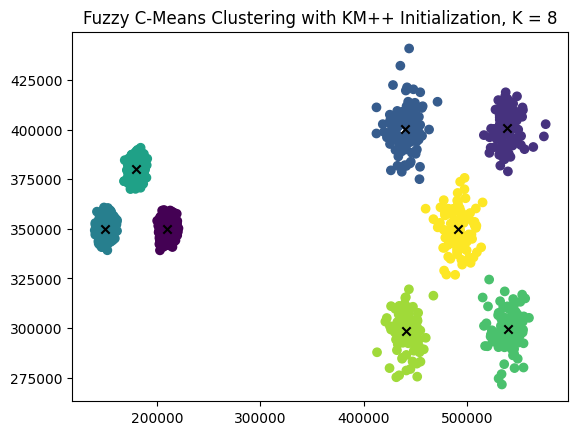

In [16]:
restart("KM++", points_unbalanced)

/tmp/ipykernel_25261/859190980.py:40: RuntimeWarning: overflow encountered in power
  memberships = 1 / np.array([np.sum((dist_j / dists) ** (2 / (CMeans.M - 1))) for dist_j in dists])


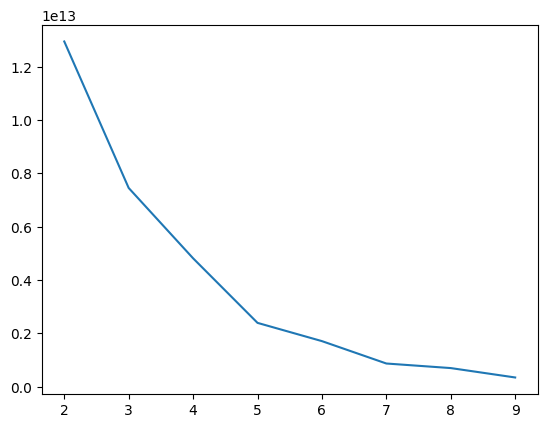

In [20]:
ks = list(range(2, 10))
costs = [CMeans(points_unbalanced, k=i).cost for i in ks]

plt.plot(ks, costs)


/tmp/ipykernel_25261/859190980.py:40: RuntimeWarning: overflow encountered in power
  memberships = 1 / np.array([np.sum((dist_j / dists) ** (2 / (CMeans.M - 1))) for dist_j in dists])


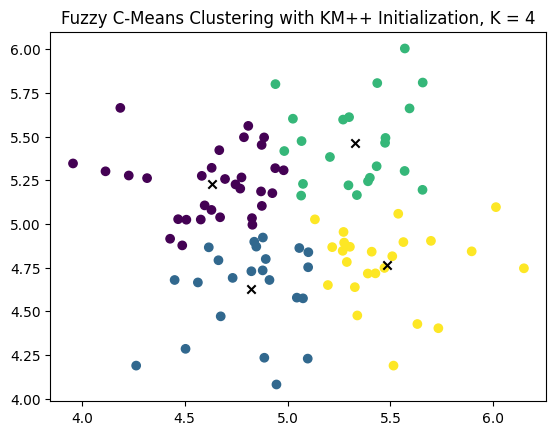

In [18]:
restart("KM++", points_normal, K=4)